In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob

In [4]:
fnames = glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T1.0_P0.*.lammpstrj')
#fnames = fnames + glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T0.700_P0.0000020000.lammpstrj')
#fnames = glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T1.0_P0.0000000000.lammpstrj')
arrays = [np.loadtxt(f, skiprows=9)[:,2:5] for f in fnames]
coordinates = np.array(arrays)
temperature = float(1.00)
side=3.
dim = len(coordinates)
n_particles = len(coordinates[0])
spacial_dim = 3
dim_ics = n_particles * spacial_dim
coordinates=coordinates.reshape(len(arrays), dim_ics)

In [5]:
print(coordinates.shape)
print(n_particles)

(1001, 30)
10


In [6]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

# a context tensor to send data to the right device and dtype via '.to(ctx)'
ctx = torch.zeros([], device=device, dtype=dtype)

# a brief check if this module is the main executable (or imported)
main = (__name__ == "__main__")

In [12]:
import sys
sys.path.insert(0, "/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/B_GEN/bgflow")
import bgflow as bg

In [13]:
from  bgflow.distribution.energy import LennardJonesPotentialPPP
rm = 2**(1./6.)
target = LennardJonesPotentialPPP(dim = dim_ics, n_particles = n_particles, side = side, oscillator = False, rm=rm, two_event_dims=False)

In [14]:
def plot_energy(coordinates, target):
    xs = torch.Tensor(coordinates)
    #xs = xs.view(-1,10,3)
    energy = target.energy(xs).detach().numpy()
    x=np.arange(1,len(energy)+1)

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, energy)

    plt.subplot(1, 2, 2)
    counts, bins = np.histogram(energy, density=True)
    plt.yscale("log")
    plt.stairs(counts, bins)

In [15]:
def save_energy(coordinates, target, step):
    xs = torch.Tensor(coordinates)
    #xs = xs.view(-1,10,3)
    energy = target.energy(xs).detach().numpy()
    x=np.arange(1,len(energy)+1)

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, energy)

    plt.subplot(1, 2, 2)
    counts, bins = np.histogram(energy, density=True)
    plt.yscale("log")
    plt.stairs(counts, bins)
    
    filename = '/home/ninarell/Desktop/FIG_ENERGY/fig_'+str(step)+".png"
    fig.savefig(filename, dpi=fig.dpi, format='png')
    plt.close()

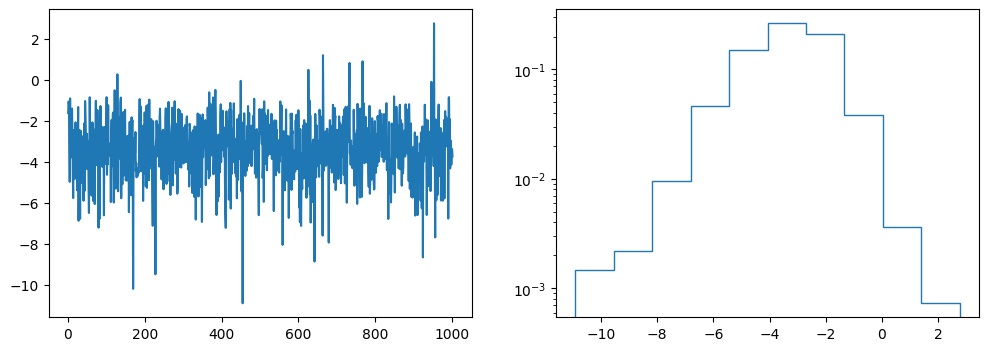

In [18]:
plot_energy(coordinates, target)

In [19]:
from bgflow import NormalDistribution, TruncatedNormalDistribution

mean = torch.Tensor(coordinates[10]).view(dim_ics)
cov = torch.zeros(dim_ics, dim_ics)
cov = cov.fill_diagonal_(0.0)

prior = NormalDistribution(dim_ics, mean=mean, cov=cov)

#upper_bound=torch.ones(dim_ics)*side
#lower_bound=-upper_bound
#sigma=torch.ones(dim_ics)*0.002
#print(upper_bound.shape, lower_bound.shape, sigma.shape, mean.shape )
#prior = TruncatedNormalDistribution(mu=mean, sigma=sigma, lower_bound=lower_bound, upper_bound=upper_bound)

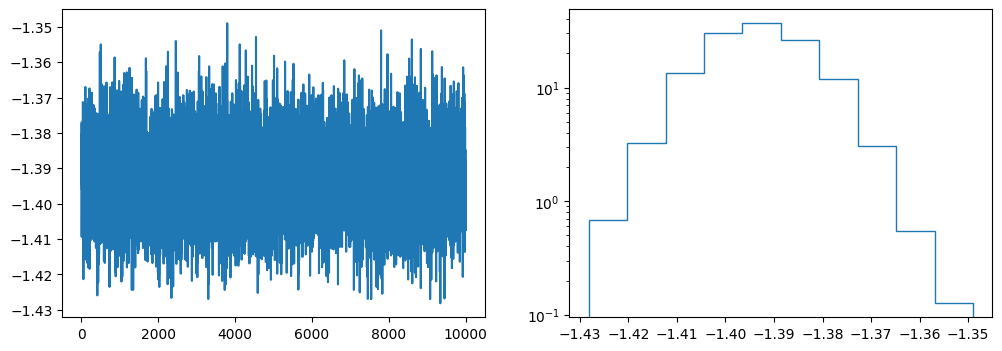

In [18]:
data_prior = prior._sample_with_temperature(10000, temperature=temperature)
#data_prior = data_prior.view(-1, 10, 3)
plot_energy(data_prior, target)

In [19]:
# define a MCMC sampler to sample from the target energy

from bgflow import GaussianMCMCSampler, LatentGaussianMCMCSampler

init_state = torch.Tensor(coordinates[10])
init_state.shape

torch.Size([30])

In [20]:
def constraint(x):
    return torch.where((abs(x) > side).clone().detach(), x - 2 * side * torch.sign(x) * torch.floor(abs(x)/side) , x)

In [21]:
from bgflow.utils.types import is_list_or_tuple
from bgflow.utils.types import assert_numpy

class LossReporter:
    """
        Simple reporter use for reporting losses and plotting them.
    """
    
    def __init__(self, *labels):
        self._labels = labels
        self._n_reported = len(labels)
        self._raw = [[] for _ in range(self._n_reported)]
    
    def report(self, *losses):
        assert len(losses) == self._n_reported
        for i in range(self._n_reported):
            self._raw[i].append(assert_numpy(losses[i]))
    
    def plot(self, n_smooth=10):
        fig, axes = plt.subplots(self._n_reported, sharex=True)
        if not isinstance(axes, np.ndarray):
            axes = [axes]
        fig.set_size_inches((8, 4 * self._n_reported), forward=True)
        for i, (label, raw, axis) in enumerate(zip(self._labels, self._raw, axes)):
            raw = assert_numpy(raw).reshape(-1)
            kernel = np.ones(shape=(n_smooth,)) / n_smooth
            smoothed = np.convolve(raw, kernel, mode="valid")
            axis.plot(smoothed)
            axis.set_xscale("log")
            axis.set_ylabel(label)
            if i == self._n_reported - 1:
                axis.set_xlabel("Iteration")
                
    def recent(self, n_recent=1):
        return np.array([raw[-n_recent:] for raw in self._raw])

In [22]:
# define a flow with RNVP coupling layers

from bgflow.nn import (
    DenseNet,
    SequentialFlow, 
    CouplingFlow, 
    AffineFlow, 
    SplitFlow, 
    InverseFlow, 
    SwapFlow,
    AffineTransformer
)



# here we aggregate all layers of the flow
layers = []

# start with a splitting layer which splits the input tensor into two 
# flow channels with tensors of half dimensionality
layers.append(SplitFlow( dim_ics//2 , dim=1))
#layers.append(SplitFlow( n_particles//2 , dim=1))

# now add coupling layers
n_coupling_layers = 4
for _ in range(n_coupling_layers):
    
    # we need to swap dimensions for the mixing
    layers.append(SwapFlow())
    
    # now set up a coupling block
    layers.append(CouplingFlow(
        # we use a affine transformation to transform the RHS conditioned on the LHS
        AffineTransformer(
            # use simple dense nets for the affine shift/scale
            shift_transformation=DenseNet([dim_ics//2, 100, 100, dim_ics//2], activation=torch.nn.ReLU(), weight_scale=0.1),
            scale_transformation=DenseNet([dim_ics//2, 100, 100, dim_ics//2], activation=torch.nn.ReLU(), weight_scale=0.1)
            #shift_transformation=DenseNet([n_particles//2, 100, 100, n_particles//2], activation=torch.nn.ReLU()),
            #scale_transformation=DenseNet([n_particles//2, 100, 100, n_particles//2], activation=torch.nn.ReLU())
        )
    ))
    
# finally, we have to merge the two channels again into one tensor
layers.append(InverseFlow(SplitFlow( dim_ics//2 , dim=1)))
    
# now define the flow as a sequence of all operations stored in layers
flow = SequentialFlow(layers)

In [23]:
# having a flow and a prior, we can now define a Boltzmann Generator

from bgflow import BoltzmannGenerator

bg = BoltzmannGenerator(prior, flow, target)

last_size  15
split_dim  1
_sizes  (15,)


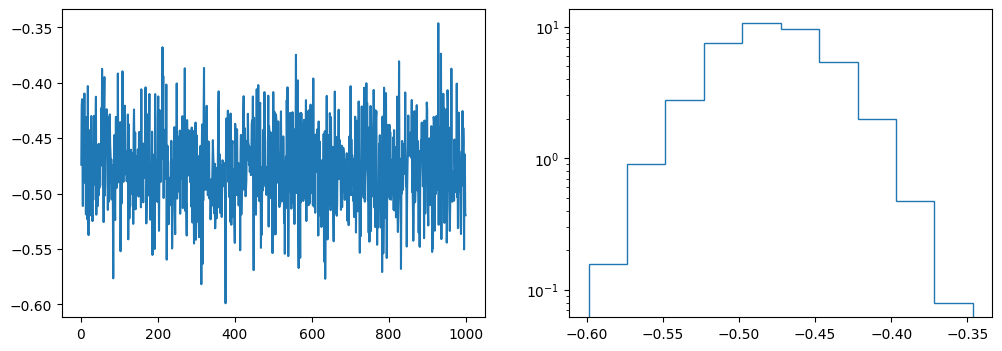

In [24]:
sample_before = bg.sample(1000, temperature=temperature)
plot_energy(sample_before , target)

In [25]:
# initial training with likelihood maximization on data set

from bgflow.utils.train import IndexBatchIterator

n_batch = 10
batch_iter = IndexBatchIterator(len(data_prior), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=5e-3, weight_decay=1e-5)

n_epochs = 10
n_report_steps = 50

reporter = LossReporter("NLL")

2024-05-16 15:37:31.130120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 15:37:31.130147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 15:37:31.131143: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 15:37:31.135138: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 15:37:31.936889: W tensorflow/compiler/tf2

In [26]:
data_prior.shape

torch.Size([10000, 30])

In [27]:
for epoch in range(n_epochs):
    for it, idxs in enumerate(batch_iter):
        #print(it, idxs, len(data))

        batch = data_prior[idxs]
        #print(idxs, batch, "\n\n")
        optim.zero_grad()
        
        # negative log-likelihood of the batch is equal to the energy of the BG
        nll = bg.energy(batch, temperature=temperature).mean()
        nll.backward()
        
        reporter.report(nll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, NLL: {3:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    *reporter.recent(1).ravel()
                ), end="")
        


last_size  15
split_dim  1
_sizes  (15,)
epoch: 0, iter: 0/1000, NLL: 2.203e+05last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 0, iter: 650/1000, NLL: -159.4last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 1, iter: 500/1000, NLL: -155.3last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 1, iter: 950/1000, NLL: -149.6last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 2, iter: 

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 2, iter: 850/1000, NLL: -153.3last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 3, iter: 500/1000, NLL: -139.6last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 4, iter: 150/1000, NLL: -145.2last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 4, iter: 350/1000, NLL: -150.6last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 5, iter: 0/1000, NLL: -150.7last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_di

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 5, iter: 450/1000, NLL: -141.9last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
epoch: 5, iter: 650/1000, NLL: -148.2last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 6, iter: 100/1000, NLL: -156.3last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 6, iter: 550/1000, NLL: -149.4last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 7, iter: 0/1000, NLL: -152.3last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_di

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 7, iter: 200/1000, NLL: -147.2last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 7, iter: 650/1000, NLL: -148.4last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 8, iter: 100/1000, NLL: -145.1last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 8, iter: 550/1000, NLL: -153.8last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
epoch: 9, iter: 0/1000, NLL: -147.6last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_di

epoch: 9, iter: 200/1000, NLL: -153.8last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
split_dim  1
_sizes  (15,)
last_size  15
sp

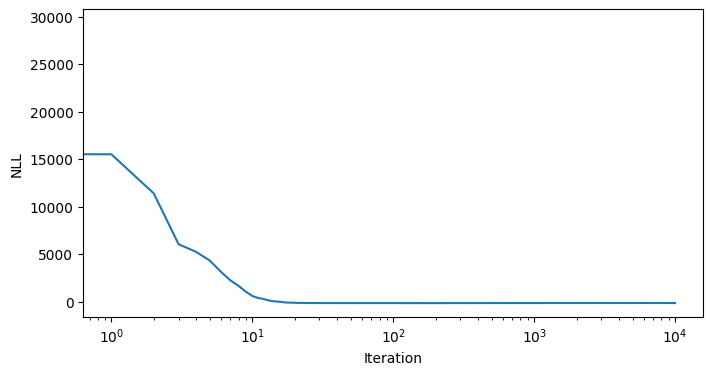

In [20]:
reporter.plot()

In [21]:
sample = bg.sample(500, temperature=temperature)

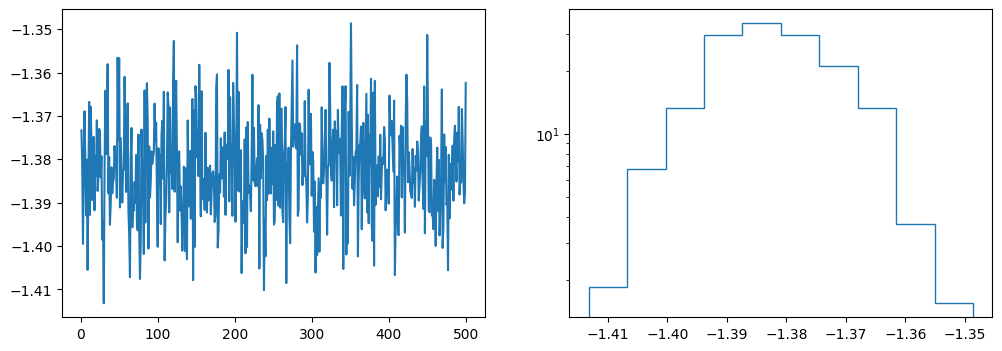

In [22]:
plot_energy(sample, target)

In [23]:
from bgflow import LatentGaussianMCMCSampler

In [24]:
# train with convex mixture of NLL and KL loss

from bgflow.utils.train import IndexBatchIterator

n_kl_samples = 10
n_batch = 10
batch_iter = IndexBatchIterator(len(data_prior), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=1e-6, weight_decay=1e-6)

n_epochs = 500
n_report_steps = 50

# mixing parameter
lambdas = torch.linspace(0.5, 0.5, n_epochs)

reporter = LossReporter("NLL", "KLL")

In [25]:
for epoch, lamb in enumerate(lambdas):
    for it, idxs in enumerate(batch_iter):
        batch = data_prior[idxs]
        
        optim.zero_grad()
        
        # negative log-likelihood of the batch is equal to the energy of the BG
        nll = bg.energy(batch).mean()
        
        # aggregate weighted gradient
        (lamb * nll).backward()
        
        # kl divergence to the target
        kll = bg.kldiv(n_kl_samples).mean()

        # aggregate weighted gradient
        ((1. - lamb) * kll).backward()
        
        reporter.report(nll, kll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, lambda: {3}, NLL: {4:.4}, KLL: {5:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    lamb,
                    *reporter.recent(1).ravel()
                ), end="")
            
            
        for i in range(len(batch)):
            sample  = batch[i:i+1]
            latent_sampler = LatentGaussianMCMCSampler(target, flow=flow, init_state=sample,temperature=temperature, noise_std=0.01)
            for j in range(1):
                 sample = latent_sampler.sample(1)
                    
            if torch.any(sample.isnan()):
                print(sample, batch[i:i+1])
            real_sample = bg.sample(1, temperature=temperature)
            if torch.any(real_sample.isnan()):
                print(sample, batch[i:i+1], real_sample)
                
            batch[i:i+1] = sample
        data_prior[idxs] = batch
    samples = bg.sample(500, temperature=temperature)
    save_energy(samples, target, str(epoch)+"_"+str(lamb))
    

epoch: 499, iter: 950/1000, lambda: 0.5, NLL: 3.045e+07, KLL: -19.29

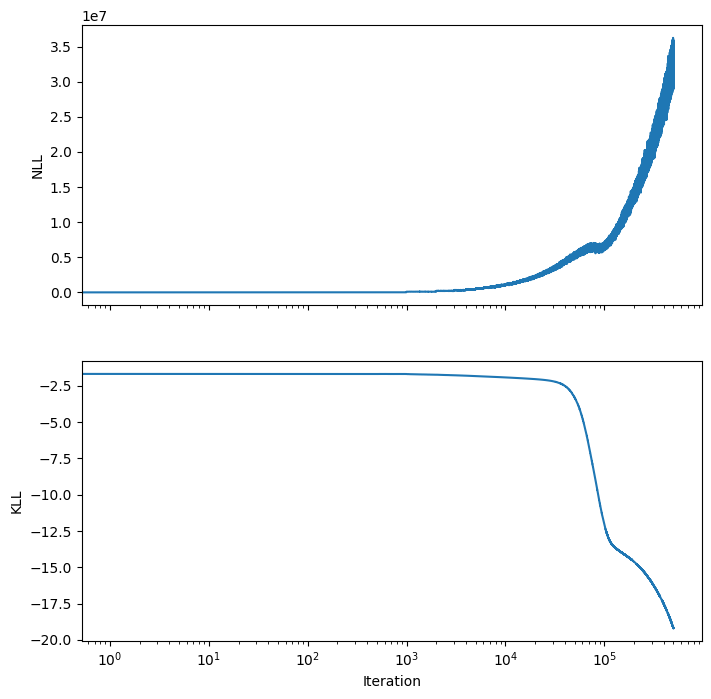

In [26]:
reporter.plot()

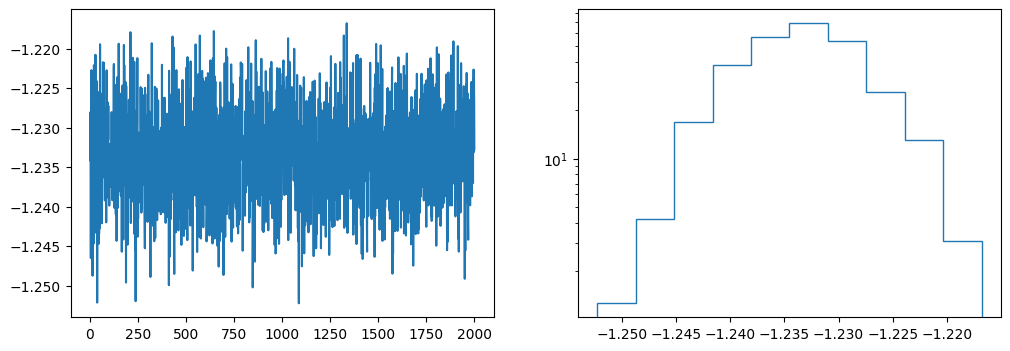

In [27]:
samples = bg.sample(2000, temperature=temperature)
plot_energy(samples,target)